In [1]:
import torch
import numpy as np
from scipy.spatial import distance
import os
import pandas as pd

import sys
sys.path.append('..')
import registry
import datafree
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'pdf'

In [2]:
!nvidia-smi

Tue Jan 31 03:36:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.60.02    Driver Version: 510.60.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0 Off |                  N/A |
| 54%   52C    P2   206W / 350W |  18191MiB / 24576MiB |     38%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 55%   

In [27]:
# CIFAR10 convergence
log_files = [
    '/data/lijingru/DataFree/checkpoints/datafree-cudfkd/log-cifar10-vgg11-resnet18-cudfkd_mem_single_3.txt',
    '../checkpoints/datafree-cudfkd/log-cifar10-vgg11-resnet18-cudfkd_L2_line91_dfq_agg3.txt',
    '../checkpoints/datafree-cudfkd/log-cifar10-vgg11-resnet18-cudfkd_L2_line91_dfq_agg_random2.txt'
]

In [28]:
!cat ../checkpoints/datafree-cudfkd/log-cifar10-vgg11-resnet18-cudfkd_L2_line91_dfq_agg_random2.txt

[07/31 11:11:10] cifar10-vgg11-resnet18 INFO: method: cudfkd
[07/31 11:11:10] cifar10-vgg11-resnet18 INFO: adv: 0.0
[07/31 11:11:10] cifar10-vgg11-resnet18 INFO: adv_type: kl
[07/31 11:11:10] cifar10-vgg11-resnet18 INFO: cond: False
[07/31 11:11:10] cifar10-vgg11-resnet18 INFO: bn: 1.0
[07/31 11:11:10] cifar10-vgg11-resnet18 INFO: oh: 1.0
[07/31 11:11:10] cifar10-vgg11-resnet18 INFO: act: 0.0
[07/31 11:11:10] cifar10-vgg11-resnet18 INFO: l1: 0.01
[07/31 11:11:10] cifar10-vgg11-resnet18 INFO: balance: 0
[07/31 11:11:10] cifar10-vgg11-resnet18 INFO: depth: 2
[07/31 11:11:10] cifar10-vgg11-resnet18 INFO: no_feature: True
[07/31 11:11:10] cifar10-vgg11-resnet18 INFO: only_feature: False
[07/31 11:11:10] cifar10-vgg11-resnet18 INFO: save_dir: run/cudfkd_test
[07/31 11:11:10] cifar10-vgg11-resnet18 INFO: no_logits: 1
[07/31 11:11:10] cifar10-vgg11-resnet18 INFO: logit_correction: mean
[07/31 11:11:10] cifar10-vgg11-resnet18 INFO: loss: kl
[07/31 11:11:10] cifar10-vgg11-resnet18 INFO: grad_m:

In [29]:
def get_res_dict(file):
    f = open(file).readlines()
    res_dict = {}
    for logs in f:
        lines = logs.strip()
    #     print(lines.split(' ')[3])
        if lines.split(' ')[4] == '[Eval]':
            if lines.split(' ')[6].startswith('Acc'):
                epoch = int(lines.split(' ')[5].split('=')[-1])
                acc = float(lines.split(' ')[6].split('=')[-1])
                res_dict[epoch] = acc
    return res_dict

In [30]:
import numpy as np
import pandas as pd
res_dicts_currkd = []
dfs = []
for f in log_files:
    res_dict = get_res_dict(f)
    real_res_dict = {'epoch': list(res_dict.keys()), 'acc': list(res_dict.values()), 'method': ['CuDFKD' for _ in range(len(res_dict))]}
    dfa = pd.DataFrame(data=real_res_dict)
    dfs.append(dfa)
    values = list(res_dict.values())
    res_dicts_currkd.append(np.array(values))
#     epochs.append()
df_currkd = pd.concat(dfs)
df_currkd.head()

,epoch,acc,method
0,0,10.0,CuDFKD
1,1,10.0,CuDFKD
2,2,10.0,CuDFKD
3,3,10.0,CuDFKD
4,4,10.0,CuDFKD


In [33]:
import pandas as pd
file_lists = [
    '/data/lijingru/DataFree/checkpoints/datafree-dafl/log-cifar10-vgg11-resnet18-dafl_interval_2.txt', 
    '../checkpoints/datafree-improved_cudfkd/log-cifar10-vgg11-resnet18-infonce_hard_reset_3.txt',
    '../checkpoints/datafree-improved_cudfkd/log-cifar10-vgg11-resnet18-infonce_hard_1.txt',
    '../checkpoints/datafree-improved_cudfkd/log-cifar10-vgg11-resnet18-infonce_s_exp7.txt',
    '../checkpoints/datafree-dfq/log-cifar10-vgg11-resnet18-dfq_test_lineb.txt',
    '../checkpoints/datafree-cmi/log-cifar10-vgg11-resnet18-cmi.txt',
    '../checkpoints/datafree-dafl/log-cifar10-vgg11-resnet18-nonnoisy_dafl_3.txt'
]
methods = ['DAFL', 'AdaDFKD', 'AdaDFKD', 'AdaDFKD','DFQ', 'CMI', 'DAFL']
# currkd_res = all_res[0]
res_dicts = dfs
for f, m in zip(file_lists, methods):
    res_dict = get_res_dict(f)
    real_res_dict = {'epoch': list(res_dict.keys())[:250], 'acc': list(res_dict.values())[:250], 'method': [m for _ in range(len(res_dict))][:250]}
    dfa = pd.DataFrame(data=real_res_dict)
    dfs.append(dfa)
    values = list(res_dict.values())
    print(len(values))

all_dfs = pd.concat(dfs)
all_dfs.head()

250
300
250
250
250
250
250


,epoch,acc,method
0,0,10.0,CuDFKD
1,1,10.0,CuDFKD
2,2,10.0,CuDFKD
3,3,10.0,CuDFKD
4,4,10.0,CuDFKD


In [34]:
import seaborn as sns
sns.set()
fig = sns.lineplot(data=all_dfs, x='epoch', y='acc', hue='method')
x_ticks = np.arange(0, 251, 50)
y_ticks = np.arange(0, 101, 20)
fig.set_xlim(0, 255)
fig.set_ylim(0, 100)
fig.set_xlabel('epoch', fontsize=14)
fig.set_ylabel('Accuracy', fontsize=14)
fig.set_xticklabels(x_ticks, fontsize=12)
fig.set_yticklabels(y_ticks, fontsize=12)
plt.savefig('cifar10.pdf')

<ipython-input-34-0f5933bc41bc>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(x_ticks, fontsize=12)
<ipython-input-34-0f5933bc41bc>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_yticklabels(y_ticks, fontsize=12)


<Figure size 432x288 with 1 Axes>

In [35]:
log_files = [
    '../checkpoints/datafree-probkd/log-cifar100-resnet34-resnet18-probkd_L2_line8.txt',
    '../checkpoints/datafree-probkd/log-cifar100-resnet34-resnet18-probkd_L2_line16.txt',
    '../checkpoints/datafree-probkd/log-cifar100-resnet34-resnet18-probkd_L2_line17.txt',
    '../checkpoints/datafree-probkd/log-cifar100-resnet34-resnet18-probkd_L2_line20.txt'
]
methods = ['CMI', 'DAFL', 'ADI']
res_dicts = []
dfs_hun = []
for f, m in zip(log_files, methods):
    res_dict = get_res_dict(f)
    real_res_dict = {'epoch': list(res_dict.keys()), 'acc': list(res_dict.values()), 'method': ['CuDFKD' for _ in range(len(res_dict))]}
    dfa = pd.DataFrame(data=real_res_dict)
    dfs_hun.append(dfa)
    values = list(res_dict.values())
    print(len(values))

df_currkd_hundred = pd.concat(dfs_hun)
df_currkd_hundred.head()

300
300
300


,epoch,acc,method
0,0,2.56,CuDFKD
1,1,8.10,CuDFKD
2,2,12.75,CuDFKD
3,3,17.61,CuDFKD
4,4,22.89,CuDFKD


In [40]:
file_lists = [
    '/data/lijingru/CMI/checkpoints/datafree-cmi/log-cifar100-resnet34-resnet18-cmi.txt',
    '../checkpoints/datafree-cmi/log-cifar100-resnet34-resnet18-cmi.txt',
    '/data/lijingru/CMI/checkpoints/datafree-dafl/log-cifar100-resnet34-resnet18.txt',
    '../checkpoints/datafree-adadfkd/log-cifar100-resnet34-resnet18-infonce_res_exp3_retest4.txt',
    '../checkpoints/datafree-dfq/log-cifar100-resnet34-resnet18-dfq_retest_line4.txt'
]

methods = ['CMI','CMI', 'DAFL', 'AdaDFKD', 'DFQ']
# currkd_res = all_res[0]
for f, m in zip(file_lists, methods):
    res_dict = get_res_dict(f)
    real_res_dict = {'epoch': list(res_dict.keys())[:300], 'acc': list(res_dict.values())[:300], 'method': [m for _ in range(len(res_dict))][:300]}
    dfa = pd.DataFrame(data=real_res_dict)
    dfs_hun.append(dfa)
    values = list(res_dict.values())
    print(len(values))

all_dfs = pd.concat(dfs_hun)
all_dfs

300
400
300
300
400


,epoch,acc,method
0,0,2.56,CuDFKD
1,1,8.10,CuDFKD
2,2,12.75,CuDFKD
3,3,17.61,CuDFKD
4,4,22.89,CuDFKD
...,...,...,...
295,295,71.20,DFQ
296,296,71.08,DFQ
297,297,70.75,DFQ
298,298,70.79,DFQ


In [41]:
sns.set()
fig = sns.lineplot(data=all_dfs, x='epoch', y='acc', hue='method')
x_ticks = np.arange(0, 300, 50)
y_ticks = np.arange(0, 80, 10)
fig.set_xlim(0, 305)
fig.set_ylim(0, 80)
fig.set_xlabel('epoch', fontsize=14)
fig.set_ylabel('Accuracy', fontsize=14)
fig.set_xticklabels(x_ticks, fontsize=12)
fig.set_yticklabels(y_ticks, fontsize=12)
plt.savefig('cifar100.pdf')

<ipython-input-41-16c24b2ac710>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(x_ticks, fontsize=12)
<ipython-input-41-16c24b2ac710>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_yticklabels(y_ticks, fontsize=12)


<Figure size 432x288 with 1 Axes>

In [47]:
distributed = False
gpu = 3
# gpu ='0,1'
batch_size = 128
workers = 8
num_classes = 10
# num_classes = 100
# num_classes = 200
def prepare_model(model):
    if not torch.cuda.is_available():
        print('using CPU, this will be slow')
        return model
    elif distributed:
        # For multiprocessing distributed, DistributedDataParallel constructor
        # should always set the single device scope, otherwise,
        # DistributedDataParallel will use all available devices.
        if gpu is not None:
#             torch.cuda.set_device(gpu)
            model.cuda()
            # When using a single GPU per process and per
            # DistributedDataParallel, we need to divide the batch size
            # ourselves based on the total number of GPUs we have
            batch_size = int(batch_size / 1)
            workers = int((workers + 1 - 1) / 1)
            model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[int(x) for x in gpu.split(',')])
            return model
        else:
            model.cuda()
            model = torch.nn.parallel.DistributedDataParallel(model)
            return model
    elif gpu is not None:
        torch.cuda.set_device(gpu)
        model = model.cuda(gpu)
        return model
    else:
        # DataParallel will divide and allocate batch_size to all available GPUs
        model = torch.nn.DataParallel(model).cuda()
        return model

In [53]:
from torchvision.datasets import CIFAR10,CIFAR100
import datafree
import registry
from torch import nn
student = registry.get_model('resnet18', num_classes=num_classes)
teacher = registry.get_model('resnet34', num_classes=num_classes, pretrained=True).eval()
# student = registry.get_model('wrn40_1', num_classes=num_classes)
# student= registry.get_model('wrn16_2', num_classes=num_classes)
# teacher = registry.get_model('wrn40_2', num_classes=num_classes)
# normalizer = datafree.utils.Normalizer(**registry.NORMALIZE_DICT['tiny_imagenet'])
normalizer = datafree.utils.Normalizer(**registry.NORMALIZE_DICT['cifar10'])
# normalizer = datafree.utils.Normalizer(**registry.NORMALIZE_DICT['cifar100'])
student = prepare_model(student)

# teacher = teacher.to(gpu)
# teacher.avgpool = nn.AdaptiveAvgPool2d(1)
# num_ftrs = teacher.linear.in_features
# teacher.linear = nn.Linear(num_ftrs, 200)
# teacher.conv1 = nn.Conv2d(3,64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
# teacher.maxpool = nn.Sequential()
teacher = prepare_model(teacher)
# ckpt = torch.load('../checkpoints/scratch/tiny_imagenet_resnet34_imagenet.pth', map_location='cpu')
# dict_ckpt = dict()
# for k, v in ckpt['state_dict'].items():
#     dict_ckpt['.'.join(k.split('.')[1:])] = v
# teacher.load_state_dict(dict_ckpt)

teacher.load_state_dict(torch.load('../checkpoints/scratch/cifar10_resnet34.pth', map_location='cpu')['state_dict'])
# teacher.load_state_dict(torch.load('../checkpoints/scratch/cifar10_wrn40_2.pth', map_location='cpu')['state_dict'])
# teacher.load_state_dict(torch.load('../checkpoints/scratch/cifar100_wrn40_2.pth', map_location='cpu')['state_dict'])
# print(ckpt['best_acc1'])
# teacher.load_state_dict(torch.load('../checkpoints/scratch/cifar100_resnet34.pth', map_location='cpu')['state_dict'])
teacher.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [50]:
# generator = datafree.models.generator.LargeGenerator(nz=512, ngf=64, img_size=32, nc=3)
# generator = prepare_model(generator)
# ckpt = torch.load('../checkpoints/datafree-deepinv/cifar100-resnet34-resnet18--deepinv_100a.pth', map_location='cpu')
# ckpt = torch.load('../checkpoints/datafree-cmi/cifar10-resnet34-resnet18_adv_cmi.pth', map_location='cpu')
# ckpt = torch.load('../checkpoints/datafree-improved_cudfkd/tiny_imagenet-resnet34_imagenet-resnet18_imagenet--improved_cudfkd_exp2-R0.pth', map_location='cpu')
# ckpt = torch.load('../checkpoints/datafree-probkd/cifar100-resnet34-resnet18--probkd_L2_line4.pth', map_location='cpu')
# ckpt = torch.load('../checkpoints/datafree-cudfkd/cifar100-resnet34-resnet18--cudfkd_L2_line33_e.pth', map_location='cpu')
# ckpt = torch.load('../checkpoints/datafree-probkd/tiny_imagenet-resnet34_imagenet-resnet18_imagenet--probkd_L3_line7-R0.pth', map_location='cpu')
# ckpt = torch.load('../checkpoints/datafree-probkd/cifar10-resnet34-resnet18--probkd_L2_line98.pth', map_location='cpu')
# ckpt = torch.load('../checkpoints/datafree-probkd/cifar10-resnet34-resnet18--probkd_L2_line73_3.pth', map_location='cpu')
# ckpt = torch.load('../checkpoints/datafree-probkd/cifar10-resnet34-resnet18--probkd_L2_line66.pth', map_location='cpu')
ckpt = torch.load('../checkpoints/datafree-improved_cudfkd/cifar10-resnet34-resnet18--infonce_s_exp6.pth', map_location='cpu')
# ckpt = torch.load('../checkpoints/datafree-deepinv/cifar10-resnet34-resnet18.pth', map_location='cpu')
# ckpt = torch.load('../checkpoints/scratch_i/cifar10_resnet18.pth', map_location='cpu')
# ckpt = torch.load('../checkpoints/scratch/cifar10_wrn16_2.pth', map_location='cpu')
# ckpt = torch.load('../checkpoints/scratch/cifar10_wrn40_1.pth', map_location='cpu')
# ckpt = torch.load('../checkpoints/scratch/cifar100_resnet18.pth', map_location='cpu')
# ckpt = torch.load('../checkpoints/datafree-cudfkd/cifar100-wrn40_2-wrn40_1--cudfkd_L2_line33_d.pth', map_location='cpu')
# ckpt = torch.load('../checkpoints/datafree-cudfkd/cifar100-wrn40_2-wrn16_2--cudfkd_L2_line34_c.pth', map_location='cpu')
print(ckpt['best_acc1'])
# dict_ckpt = dict()
# for k, v in ckpt['state_dict'].items():
#     dict_ckpt['.'.join(k.split('.')[1:])] = v
# G_ckpt = ckpt['G']

student = prepare_model(student)
# student.avgpool = nn.AdaptiveAvgPool2d(1)
# num_ftrs = student.linear.in_features
# student.fc = nn.Linear(num_ftrs, 200)
# student.conv1 = nn.Conv2d(3,64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
# student.maxpool = nn.Sequential()
student.load_state_dict(ckpt['state_dict'])
# student.load_state_dict(dict_ckpt)
student.eval()


95.00999999999999


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [17]:
g = datafree.models.generator.DCGAN_Generator_CIFAR10(nz=1024, ngf=64, nc=3, img_size=64, d=3, cond=False)
g = prepare_model(g)
dict_ckpt = {}
for k, v in G_ckpt.items():
    dict_ckpt['.'.join(k.split('.')[1:])] = v
g.load_state_dict(dict_ckpt)

<All keys matched successfully>

In [18]:
from torchvision.utils import save_image,make_grid
z = torch.randn(256, 1024).to(gpu)
x = g(z)
img = make_grid(x, nrow=16, padding=2,normalize=True)
save_image(img, 'visualize_timage.jpg')

In [52]:
import torchvision.transforms as T
from registry import NORMALIZE_DICT
from torchvision import datasets
# normalizer = datafree.utils.Normalizer(**registry.NORMALIZE_DICT['cifar10'])
# val_transform = T.Compose([
#     #T.Resize((224, 224), Image.BICUBIC),
#     T.ToTensor(),
#     T.Normalize( **NORMALIZE_DICT['tiny_imagenet'] ),
# ])
val_transform = T.Compose([
    T.ToTensor(),
    T.Normalize( **NORMALIZE_DICT['cifar10'] )]
) 

val_dst = datasets.CIFAR10('~/cifar10/', train=False, download=True, transform=val_transform)
# val_dst = datasets.CIFAR100('~/cifar100/', train=False, download=True, transform=val_transform)
# val_dst = datasets.ImageFolder(os.path.join('~/timagenet/tiny-imagenet-200', 'val_split'), transform=val_transform)

val_loader = torch.utils.data.DataLoader(val_dst, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

Files already downloaded and verified


In [53]:
import tqdm
probs_s = []
probs_t = []
ys = []
for x, y in tqdm.tqdm(val_loader, desc='calculate_agg'):
    s_out = student(x.to(gpu))
    t_out = teacher(x.to(gpu))
#     print(np.argmax(prob_t, 1), y.numpy())
#     print(torch.sum(s_out.argmax(1).detach().cpu() == y) / 128)
    prob_s = torch.softmax(s_out.detach(), 1).cpu().numpy()
    probs_s.append(prob_s)
    prob_t = torch.softmax(t_out.detach(), 1).cpu().numpy()
    probs_t.append(prob_t)
    ys.append(y.numpy())

probs_s = np.concatenate(probs_s, 0)
probs_t = np.concatenate(probs_t, 0)
ys = np.concatenate(ys, 0)

calculate_agg: 100%|██████████| 79/79 [00:04<00:00, 19.67it/s]


In [54]:
if not os.path.exists('prob_loyalty_distribution/'):
    os.mkdir('prob_loyalty_distribution/')
# print(y)
print(np.sum(np.argmax(probs_s, 1) == ys) / len(val_dst))
print(np.sum(np.argmax(probs_t, 1) == ys) / len(val_dst))
print(np.sum(np.argmax(probs_t, 1) == np.argmax(probs_s, 1)) / len(val_dst))
dist = distance.jensenshannon(probs_s.T, probs_t.T)
dist[np.isnan(dist)] = 0 if np.sum(np.abs(probs_s[np.where(np.isnan(dist))] - probs_t[np.where(np.isnan(dist))])) < 1e-6 else 1
prob_loyalty = 1 - np.sqrt(dist)
print(np.nanmean(prob_loyalty))
# print(dist[1773])

0.9302
0.957
0.9394
0.81585


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = sns.displot(prob_loyalty, kind='hist', color=sns.xkcd_rgb["yellow orange"])
# fig.set_xlim(0, 1)
fig.set_xlabels('probability loyalty', fontsize=14)
fig.set_ylabels('Number of Images', fontsize=14)
# plt.savefig('prob_loyalty_distribution/prob_loyalty_cudfkd.pdf')
# x_ticks = np.arange(0, 1.01, 0.2)
# y_ticks = np.arange(0, 700, 100)
# fig.set_xticklabels(x_ticks, fontsize=12)
# fig.set_yticklabels(y_ticks, fontsize=12)


<Figure size 360x360 with 1 Axes>

### Other visualization Results
The items for further visualization:
- Difficulty visualization at different timestage.
- Ablation study of $k$ and $N_{neg}$.
- Error bar of AdaDFKD, CuDFKD, CMI, ADI and DAFL.

In [26]:
x = np.array(['1/5', '1/4', '1/3'])
y = np.array(['2/3', '3/4', '4/5'])
res2res_acc = np.array([[71.00, 71.22, 71.12], [70.81, 70.79, 70.68], [70.41, 70.52, 70.54]])
res2res_agr = np.array([[85.88, 85.85, 85.64], [85.40, 85.14, 85.58], [83.77, 83.88, 83.67]])
res2res_loyalty = np.array([[0.6659, 0.6777, 0.6751], [0.6684, 0.6624, 0.6682], [0.6469, 0.6500, 0.6467]])

In [14]:
if not os.path.exists('heatmaps/'):
    os.mkdir('heatmaps/')
fig1 = sns.heatmap(res2res_acc, xticklabels=x, yticklabels=y, annot=True, fmt='.2f', cmap='RdBu_r')
plt.savefig('heatmaps/vgg_acc.pdf')

<Figure size 432x288 with 2 Axes>

In [15]:
fig2 = sns.heatmap(res2res_agr, xticklabels=x, yticklabels=y, annot=True, fmt='.2f', cmap='RdBu_r')
plt.savefig('heatmaps/vgg_agg.pdf')

<Figure size 432x288 with 2 Axes>

In [16]:
fig3 = sns.heatmap(res2res_loyalty, xticklabels=x, yticklabels=y, annot=True, fmt='.4f', cmap='RdBu_r')
plt.savefig('heatmaps/vgg_loyalty.pdf')

<Figure size 432x288 with 2 Axes>

In [17]:
vgg2res_acc = np.array([[64.74, 64.65, 64.77], [64.66, 64.66, 64.10], [63.95, 64.00, 63.81]])
vgg2res_agr = np.array([[68.91, 68.88, 68.93], [68.80, 68.85, 68.54], [68.58, 68.19, 68.31]])
vgg2res_loyalty = np.array([[0.5067, 0.5058, 0.5072], [0.5059, 0.5054, 0.5069], [0.5001, 0.4961, 0.5021]])

In [18]:
sns.heatmap(vgg2res_acc, xticklabels=x, yticklabels=y, annot=True, fmt='.2f', cmap='RdBu_r')
plt.savefig('heatmaps/wrn_acc.pdf')

<Figure size 432x288 with 2 Axes>

In [19]:
sns.heatmap(vgg2res_agr, xticklabels=x, yticklabels=y, annot=True, fmt='.2f', cmap='RdBu_r')
plt.savefig('heatmaps/wrn_agg.pdf')

<Figure size 432x288 with 2 Axes>

In [20]:
sns.heatmap(vgg2res_loyalty, xticklabels=x, yticklabels=y, annot=True, fmt='.4f', cmap='RdBu_r')
plt.savefig('heatmaps/wrn_loyalty.pdf')

<Figure size 432x288 with 2 Axes>

In [106]:
ckpt = torch.load('../checkpoints/datafree-cudfkd/cifar100-wrn40_2-wrn40_1--cudfkd_L2_line33_d.pth', map_location='cpu')
student.load_state_dict(ckpt['state_dict'])
student.eval()
g = datafree.models.generator.DCGAN_Generator_CIFAR10(nz=512, ngf=64, nc=3, img_size=32, d=2, cond=False)
g = prepare_model(g)
g.load_state_dict(ckpt['G_0'])
g.eval()

DCGAN_Generator_CIFAR10(
  (project): Sequential(
    (0): Flatten()
    (1): Linear(in_features=512, out_features=16384, bias=True)
  )
  (main): Sequential(
    (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Sigmoid()
  )
)

In [107]:
from torchvision.utils import make_grid,save_image
diff = []
now_epoch = 300
kl_metric = datafree.criterions.KLDiv(T=2., reduction='none')
with torch.no_grad():
    for i in range(20):
        z = torch.randn(1024, 512).to(gpu)
        x = g(z)
        t_out = teacher(normalizer(x))
        s_out = student(normalizer(x))
        kl_diff = kl_metric(t_out, s_out).sum(1).detach().cpu().numpy()
        diff.append(kl_diff)
    
diff = np.concatenate(diff)
print(diff)
with torch.no_grad():
    z = torch.randn(1024, 512).to(gpu)
    img = make_grid(x, nrow=16)
    t_out = teacher(normalizer(x))
    pesudo_label = t_out.argmax(1).cpu().numpy()
    print(pesudo_label)

#     save_image(img, 'difficulty/epoch_{}.jpg'.format(now_epoch))

[0.8088592  0.78664553 2.6981955  ... 2.2897153  1.3273132  1.1442074 ]
[13 85 81 ... 23 98 67]


In [108]:
xs = []
for i in range(num_classes):
#     print(i)
    xs.append(x[pesudo_label == i].cpu())
    print(i, xs[i].shape)
    if xs[i].shape[0] > 0:
        img = make_grid(xs[i], nrow=1)
        save_image(img, 'difficulty/img_epoch_{}_{}.jpg'.format(now_epoch, i))

0 torch.Size([9, 3, 32, 32])
1 torch.Size([8, 3, 32, 32])
2 torch.Size([8, 3, 32, 32])
3 torch.Size([13, 3, 32, 32])
4 torch.Size([13, 3, 32, 32])
5 torch.Size([18, 3, 32, 32])
6 torch.Size([10, 3, 32, 32])
7 torch.Size([15, 3, 32, 32])
8 torch.Size([8, 3, 32, 32])
9 torch.Size([13, 3, 32, 32])
10 torch.Size([12, 3, 32, 32])
11 torch.Size([14, 3, 32, 32])
12 torch.Size([12, 3, 32, 32])
13 torch.Size([15, 3, 32, 32])
14 torch.Size([10, 3, 32, 32])
15 torch.Size([6, 3, 32, 32])
16 torch.Size([5, 3, 32, 32])
17 torch.Size([13, 3, 32, 32])
18 torch.Size([3, 3, 32, 32])
19 torch.Size([8, 3, 32, 32])
20 torch.Size([7, 3, 32, 32])
21 torch.Size([7, 3, 32, 32])
22 torch.Size([15, 3, 32, 32])
23 torch.Size([12, 3, 32, 32])
24 torch.Size([5, 3, 32, 32])
25 torch.Size([5, 3, 32, 32])
26 torch.Size([12, 3, 32, 32])
27 torch.Size([15, 3, 32, 32])
28 torch.Size([10, 3, 32, 32])
29 torch.Size([21, 3, 32, 32])
30 torch.Size([13, 3, 32, 32])
31 torch.Size([13, 3, 32, 32])
32 torch.Size([5, 3, 32, 32])


In [21]:
sns.displot(diff)

<Figure size 360x360 with 1 Axes>

In [21]:
wrn2wrn_acc = np.array([[75.24, 75.16, 75.31], [75.11, 75.21, 75.22], [75.01, 74.89, 75.01]])
wrn2wrn_agr = np.array([[85.26, 86.06, 86.11], [85.40, 85.14, 85.58], [85.38, 85.53, 85.57]])
wrn2wrn_loyalty = np.array([[0.6472, 0.6476, 0.6476], [0.6433, 0.6437, 0.6447], [0.6393, 0.6403, 0.6407]])


In [22]:
sns.heatmap(wrn2wrn_acc, xticklabels=x, yticklabels=y, annot=True, fmt='.2f', cmap='RdBu_r')
plt.savefig('heatmaps/res_acc.pdf')

<Figure size 432x288 with 2 Axes>

In [23]:
sns.heatmap(wrn2wrn_agr, xticklabels=x, yticklabels=y, annot=True, fmt='.2f', cmap='RdBu_r')
plt.savefig('heatmaps/res_agg.pdf')

<Figure size 432x288 with 2 Axes>

In [25]:
sns.heatmap(wrn2wrn_loyalty, xticklabels=x, yticklabels=y, annot=True, fmt='.4f', cmap='RdBu_r')
plt.savefig('heatmaps/res_loyalty.pdf')

<Figure size 432x288 with 2 Axes>

In [7]:
import pandas as pd
grad_range = np.array([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4])
adv_acc = np.array([75.10, 75.31, 75.50, 75.50, 75.51, 75.60, 75.73, 75.67])
adv_agg = np.array([85.52, 86.11, 86.22, 86.52, 86.30, 86.52, 86.32, 86.11])
adv_loyalty = np.array([0.6412, 0.6476, 0.6528, 0.6568, 0.6571, 0.6576, 0.6575, 0.6572])
if not os.path.exists('grad_adv/'):
    os.mkdir('grad_adv/')

res_dict = {
    'grad_of_adv': grad_range,
    'acc@1': adv_acc,
    'agree@1': adv_agg,
    'loyalty': adv_loyalty
}

final_df = pd.DataFrame(res_dict)
final_df

,grad_of_adv,acc@1,agree@1,loyalty
0,0.5,75.10,85.52,0.6412
1,1.0,75.31,86.11,0.6476
2,1.5,75.50,86.22,0.6528
3,2.0,75.50,86.52,0.6568
4,2.5,75.51,86.30,0.6571
5,3.0,75.60,86.52,0.6576
6,3.5,75.73,86.32,0.6575
7,4.0,75.67,86.11,0.6572


In [109]:
# now_epoch = 300
global_iter = now_epoch * 400
lamda = datafree.datasets.utils.lambda_scheduler(1.0, global_iter, alpha=0.00002)
g,v = datafree.datasets.utils.curr_v(l=torch.FloatTensor(diff), lamda=lamda, spl_type='log')

In [110]:
if not os.path.exists('difficulty/'):
    os.mkdir('difficulty/')
diffs = dict()
diffs['epoch@{}'.format(now_epoch)] = v.numpy() * diff
# sns.displot(v.numpy() * diff, kind='kde')
# plt.savefig('difficulty/difficulty_at_{}.pdf'.format(now_epoch))

In [51]:
# ckpt = torch.load('../checkpoints/datafree-', map_location='cpu')
# student.load_state_dict(ckpt['state_dict'])
# student.eval()
g = datafree.models.generator.DCGAN_Generator_CIFAR10(nz=512, ngf=64, nc=3, img_size=32, d=2, cond=False)
g = prepare_model(g)
g.load_state_dict(ckpt['G'])
g.eval()

DCGAN_Generator_CIFAR10(
  (project): Sequential(
    (0): Flatten()
    (1): Linear(in_features=512, out_features=16384, bias=True)
  )
  (main): Sequential(
    (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Sigmoid()
  )
)

In [58]:
import torch.nn.functional as F
ds = []
with torch.no_grad():
    for i in range(50):
        z = torch.randn(256, 512).to(gpu)
        x = g(z)
#         print(x.device)
        t_out, t_feat = teacher(normalizer(x), return_features=True)
        s_out, s_feat = student(normalizer(x), return_features=True)
        normalized_t, normalized_s = F.normalize(t_feat, dim=-1), F.normalize(s_feat, dim=-1)
    
        d = torch.mm(normalized_t, normalized_s.T)
        label = torch.arange(len(t_feat), dtype=torch.long, device=gpu)
        loss_infonce = F.cross_entropy(d / 0.07, label, reduction='none')
#         print(loss_infonce.shape)
        ds.append(loss_infonce.cpu())
#         n = d.size(0)
#         # Div(t, s) at feature map space.
#         p = torch.softmax(d / tau, 1)
print(torch.cat(ds))

tensor([5.6766, 5.4825, 5.6135,  ..., 5.6633, 5.6543, 5.6680])


In [65]:
import seaborn as sns
ds_250 = torch.cat(ds)
# sns.displot(torch.cat(ds), kind='kde')

In [75]:
ckpt = torch.load('../checkpoints/datafree-improved_cudfkd/cifar10-resnet34-resnet18-10.pth', map_location='cpu')
student.load_state_dict(ckpt['state_dict'])
g = datafree.models.generator.DCGAN_Generator_CIFAR10(nz=512, ngf=64, nc=3, img_size=32, d=2, cond=False)
g = prepare_model(g)
g.load_state_dict(ckpt['G'])
g.eval()

DCGAN_Generator_CIFAR10(
  (project): Sequential(
    (0): Flatten()
    (1): Linear(in_features=512, out_features=16384, bias=True)
  )
  (main): Sequential(
    (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Sigmoid()
  )
)

In [76]:
import torch.nn.functional as F
ds = []
with torch.no_grad():
    for i in range(50):
        z = torch.randn(256, 512).to(gpu)
        x = g(z)
#         print(x.device)
        t_out, t_feat = teacher(normalizer(x), return_features=True)
        s_out, s_feat = student(normalizer(x), return_features=True)
        normalized_t, normalized_s = F.normalize(t_feat, dim=-1), F.normalize(s_feat, dim=-1)
    
        d = torch.mm(normalized_t, normalized_s.T)
        label = torch.arange(len(t_feat), dtype=torch.long, device=gpu)
        loss_infonce = F.cross_entropy(d / 0.07, label, reduction='none')
#         print(loss_infonce.shape)
        ds.append(loss_infonce.cpu())
#         n = d.size(0)
#         # Div(t, s) at feature map space.
#         p = torch.softmax(d / tau, 1)
ds_10 = torch.cat(ds)
print(ds_10)

tensor([5.2373, 6.9553, 6.0906,  ..., 5.9348, 4.1549, 4.7906])


In [77]:
ds_dict = {
    'epoch@10': ds_10,
    'epoch@250': ds_250,
}
sns.displot(ds_dict, kind='kde')

<Figure size 455.25x360 with 1 Axes>

In [119]:
diff = []
now_epoch = 10
kl_metric = datafree.criterions.KLDiv(T=2., reduction='none')
with torch.no_grad():
    for i in range(20):
        z = torch.randn(1024, 512).to(gpu)
        x = g(z)
        t_out = teacher(normalizer(x))
        s_out = student(normalizer(x))
        kl_diff = kl_metric(t_out, s_out).sum(1).detach().cpu().numpy()
        diff.append(kl_diff)
    
diff = np.concatenate(diff)
print(diff)
with torch.no_grad():
    z = torch.randn(1024, 512).to(gpu)
    x = g(z)
    img = make_grid(x, nrow=16)
    t_out = teacher(normalizer(x))
    pesudo_label = t_out.argmax(1).cpu().numpy()
    print(pesudo_label)
    save_image(img, 'difficulty/epoch_{}.jpg'.format(now_epoch))

[0.72593755 1.0575736  1.4061728  ... 0.61674047 1.2157195  0.48502705]
[81 70 89 ...  1 19 25]


In [120]:
xs = []
for i in range(num_classes):
#     print(i)
    xs.append(x[pesudo_label == i].cpu())
    print(i, xs[i].shape)
    if xs[i].shape[0] > 0:
        img = make_grid(xs[i], nrow=1)
        save_image(img, 'difficulty/img_epoch_{}_{}.jpg'.format(now_epoch, i))

0 torch.Size([3, 3, 32, 32])
1 torch.Size([23, 3, 32, 32])
2 torch.Size([2, 3, 32, 32])
3 torch.Size([8, 3, 32, 32])
4 torch.Size([12, 3, 32, 32])
5 torch.Size([12, 3, 32, 32])
6 torch.Size([6, 3, 32, 32])
7 torch.Size([21, 3, 32, 32])
8 torch.Size([17, 3, 32, 32])
9 torch.Size([11, 3, 32, 32])
10 torch.Size([9, 3, 32, 32])
11 torch.Size([7, 3, 32, 32])
12 torch.Size([10, 3, 32, 32])
13 torch.Size([11, 3, 32, 32])
14 torch.Size([11, 3, 32, 32])
15 torch.Size([8, 3, 32, 32])
16 torch.Size([7, 3, 32, 32])
17 torch.Size([6, 3, 32, 32])
18 torch.Size([4, 3, 32, 32])
19 torch.Size([12, 3, 32, 32])
20 torch.Size([2, 3, 32, 32])
21 torch.Size([1, 3, 32, 32])
22 torch.Size([5, 3, 32, 32])
23 torch.Size([14, 3, 32, 32])
24 torch.Size([8, 3, 32, 32])
25 torch.Size([8, 3, 32, 32])
26 torch.Size([13, 3, 32, 32])
27 torch.Size([6, 3, 32, 32])
28 torch.Size([13, 3, 32, 32])
29 torch.Size([17, 3, 32, 32])
30 torch.Size([18, 3, 32, 32])
31 torch.Size([8, 3, 32, 32])
32 torch.Size([8, 3, 32, 32])
33 to

In [121]:
# now_epoch = 10
global_iter = now_epoch * 400
lamda = datafree.datasets.utils.lambda_scheduler(1.0, global_iter, alpha=0.00002)
g,v = datafree.datasets.utils.curr_v(l=torch.FloatTensor(diff), lamda=lamda, spl_type='log')
diffs['epoch@{}'.format(now_epoch)] = v.numpy() * diff

In [122]:
print(len(diffs['epoch@10']), len(diffs['epoch@300']))
ax = sns.displot(diffs, kind='kde')
ax.set_xlabels('Difficulty', fontsize=12)
# plt.savefig('difficulty/difficulty_wrn402_wrn162_cifar100.pdf')

20480 20480


<Figure size 455x360 with 1 Axes>

In [123]:
res_acc_dict = {
    'method': ['cudfkd', 'cudfkd', 'cudfkd', 'teacher', 'adi', 'adi', 'adi', 'dafl', 'dafl', 'dafl', 'cmi', 'cmi', 'cmi'],
    'acc@1': [95.24, 95.28, 95.15, 95.70],
    'agree@1': [98.20, 98.19, 98.09, 100.00],
    'prob_loyalty': [0.8909, 0.8903, 0.8898, 1.00],
}

In [38]:
fig, ax1 = plt.subplots()
width = 0.4
x1_list = []
x2_list = []
for i in range(adv_acc.shape[0]):
    x1_list.append(i)
    x2_list.append(i + width)

# b1 = sns.lineplot(data=final_df, x="grad_of_adv", y="acc@1",color=sns.xkcd_rgb["pale red"] )  
b1, = plt.plot(final_df["grad_of_adv"], final_df["acc@1"], '-ro', label='Accuracy@1')

# b1 = ax1.bar(x1_list, adv_acc, width=width, label='Acc@1', color=sns.xkcd_rgb["pale red"], tick_label=grad_range)
ax2 = ax1.twinx()
b2, = plt.plot(final_df["grad_of_adv"], final_df["agree@1"], '-bo', label='Agreement@1')
# plt.grid('off')
# b2 = sns.lineplot(data=final_df, x="grad_of_adv", y="agree@1", color=sns.xkcd_rgb["denim blue"])
# b2 = ax2.bar(x2_list, adv_agg, width=width, label='Agree@1', color=sns.xkcd_rgb["denim blue"], tick_label=grad_range)
ax1.set_xlabel('grad of adv', fontsize=12)
ax1.set_ylabel('Accuracy@1', fontsize=12)
ax2.set_ylabel('Agreement@1', fontsize=12)
ax1.set_ylim(74, 77)
ax2.set_ylim(85, 87)
axs = [b1, b2]
lbs = [ax.get_label() for ax in axs]
ax1.legend(axs, lbs)
plt.savefig('grad_adv/acc_agg.pdf')
# plt.legend(['a', 'b'])
# plt.grid('off')

<Figure size 432x288 with 2 Axes>

In [39]:
plt.plot(final_df["grad_of_adv"], final_df["loyalty"], '-go', label="prob_loyalty")
plt.ylim(0.64, 0.66)
x_ticks = final_df["grad_of_adv"]
y_ticks = np.arange(0.64, 0.66, 0.005)
plt.xlabel('grad of adv', fontsize=14)
plt.ylabel('probability loyalty', fontsize=14)
plt.xticks(x_ticks, fontsize=12)
plt.yticks(y_ticks, fontsize=12)
plt.savefig('grad_adv/prob_loyalty.pdf')

<Figure size 432x288 with 1 Axes>

In [25]:
curriculum_dict={
    'method': ['teacher', 'None', 'hard', 'soft', 'log','teacher', 'None', 'hard', 'soft', 'log','teacher', 'None', 'hard', 'soft', 'log'],
    'accuracy': [95.70, 93.24, 94.97, 95.01, 95.28, 100.00, 94.00, 97.71, 97.74, 98.13, 1.0000, 0.8202, 0.8813, 0.8786, 0.8909],
    'metric': ['Acc@1','Acc@1','Acc@1','Acc@1','Acc@1','Agree@1','Agree@1','Agree@1','Agree@1','Agree@1','prob loyalty','prob loyalty','prob loyalty','prob loyalty','prob loyalty']
}
curr_df = pd.DataFrame(curriculum_dict)
curr_df
curr_dict={
    'curriculum strategy': ['teacher', 'None', 'hard', 'soft', 'log'],
    'Acc@1': [95.70, 93.24, 94.97, 95.01, 95.28],
    'Agree@1': [100.00, 94.00, 97.71, 97.74, 98.13],
    'probability loyalty': [1.0000, 0.8202, 0.8813, 0.8786, 0.8909]
}
curr_dfs = pd.DataFrame(curr_dict)

if not os.path.exists('curr_strategy/'):
    os.mkdir('curr_strategy/')

In [26]:
fig, ax1 = plt.subplots()
width = 0.4
x1_list = []
x2_list = []
for i in range(5):
    x1_list.append(i)
    x2_list.append(i + width)

# b1 = sns.lineplot(data=final_df, x="grad_of_adv", y="acc@1",color=sns.xkcd_rgb["pale red"] )  
# b1, = plt.plot(final_df["grad_of_adv"], final_df["acc@1"], '-ro', label='Accuracy@1')
# b1 = sns.barplot(data=curriculum_dict, x='method', y='accuracy', color=sns.xkcd_rgb["pale red"])
b1 = ax1.bar(x1_list, curr_df['accuracy'][:5], width=width, label='Acc@1', color=sns.xkcd_rgb["pale red"], tick_label=curriculum_dict['method'][:5])
ax2 = ax1.twinx()
# b2, = plt.plot(final_df["grad_of_adv"], final_df["agree@1"], '-bo', label='Agreement@1')
# plt.grid('off')
# b2 = sns.lineplot(data=final_df, x="grad_of_adv", y="agree@1", color=sns.xkcd_rgb["denim blue"])
b2 = ax2.bar(x2_list, curr_df['accuracy'][5:10], width=width, label='Agree@1', color=sns.xkcd_rgb["denim blue"], tick_label=curriculum_dict['method'][:5])
# ax2 = ax1.twinx()
# b2 = sns.barplot(data=curriculum_dict, x='method', y='Agree@1', color=sns.xkcd_rgb["denim blue"])
ax1.set_xlabel('Curriculum strategy', fontsize=14)
ax1.set_ylabel('Accuracy@1', fontsize=14)
ax2.set_ylabel('Agreement@1', fontsize=14)
ax1.set_ylim(93, 96)
ax2.set_ylim(92, 101)
# ax2.set_yticklabels(np.arange(92, 101, 2))
axs = [b1, b2]
lbs = [ax.get_label() for ax in axs]
# ax1.legend()
ax1.legend(axs, lbs)
plt.savefig('curr_strategy/acc_agg.pdf')

<Figure size 432x288 with 2 Axes>

In [22]:
# plt.bar(x1_list, curr_df['accuracy'][-5:], width=width, label='prob_loyalty', color=sns.xkcd_rgb["dark green"], tick_label=['teacher', 'None', 'hard', 'soft', 'log'])
ax = sns.barplot(data=curr_dfs, x='curriculum strategy', y='probability loyalty', color=sns.xkcd_rgb["green"])
plt.ylim(0.8, 1.01)
# x_ticks = final_df["grad_of_adv"]
# x_ticks = ['teacher', 'None', 'hard', 'soft', 'log']
# y_ticks = np.arange(0.8, 1.01, 0.05)
plt.xlabel('curriculum strategy', fontsize=14)
plt.ylabel('probability loyalty', fontsize=14)
# plt.xticks(x_ticks, fontsize=12)
# plt.yticks(y_ticks, fontsize=12)
# plt.legend()
plt.savefig('curr_strategy/prob_loyalty.pdf')

<Figure size 432x288 with 1 Axes>

In [47]:
if not os.path.exists('T/'):
    os.mkdir('T/')
T_dict = {
    'T': [4, 5, 8, 10, 12, 15, 18, 20],
    'accuracy@1': [94.96, 95.01,94.94,94.93,94.97, 95.03, 94.94, 95.28],
    'agreement@1': [97.86, 97.64, 97.79, 97.63, 97.60, 97.69, 97.74, 98.20],
    'prob_loyalty': [0.8777, 0.8774, 0.8807, 0.8739, 0.8771, 0.8801, 0.8793, 0.8909]
    
}


In [50]:
fig, ax1 = plt.subplots()
width = 0.4
x1_list = []
x2_list = []
for i in range(adv_acc.shape[0]):
    x1_list.append(i)
    x2_list.append(i + width)

# b1 = sns.lineplot(data=final_df, x="grad_of_adv", y="acc@1",color=sns.xkcd_rgb["pale red"] )  
b1, = plt.plot(T_dict["T"], T_dict['accuracy@1'], '-ro', label='Accuracy@1')

# b1 = ax1.bar(x1_list, adv_acc, width=width, label='Acc@1', color=sns.xkcd_rgb["pale red"], tick_label=grad_range)
ax2 = ax1.twinx()
b2, = plt.plot(T_dict["T"], T_dict['agreement@1'], '-bo', label='Agreement@1')
# plt.grid('off')
# b2 = sns.lineplot(data=final_df, x="grad_of_adv", y="agree@1", color=sns.xkcd_rgb["denim blue"])
# b2 = ax2.bar(x2_list, adv_agg, width=width, label='Agree@1', color=sns.xkcd_rgb["denim blue"], tick_label=grad_range)
ax1.set_xlabel('T', fontsize=12)
ax1.set_ylabel('Accuracy@1', fontsize=12)
ax2.set_ylabel('Agreement@1', fontsize=12)
ax1.set_ylim(94, 95.5)
ax2.set_ylim(97, 99)
axs = [b1, b2]
lbs = [ax.get_label() for ax in axs]
ax1.legend(axs, lbs)
plt.savefig('T/acc_agg.pdf')

<Figure size 432x288 with 2 Axes>

In [54]:
plt.plot(T_dict["T"], T_dict["prob_loyalty"], '-go', label="prob_loyalty")
plt.ylim(0.87, 0.9)
x_ticks = np.arange(4, 21, 4)
y_ticks = np.arange(0.87, 0.9, 0.005)
plt.xlabel('T', fontsize=14)
plt.ylabel('probability loyalty', fontsize=14)
plt.xticks(x_ticks, fontsize=12)
plt.yticks(y_ticks, fontsize=12)
plt.savefig('T/prob_loyalty.pdf')

<Figure size 432x288 with 1 Axes>

In [50]:
if not os.path.exists('lambda_0/'):
    os.mkdir('lambda_0/')
lambda_0_dict = {
    'lambda_0': [2, 2.2, 2.5, 2.8],
    'accuracy@1': [93.34,93.24,93.17,93.10],
    'agreement@1': [94.15, 94.02, 93.92, 93.97],
    'loyalty': [0.8183, 0.8176, 0.8173, 0.8170],
    'curriculum': ['logarithm', 'logarithm', 'logarithm', 'logarithm']
}



In [52]:
fig, ax1 = plt.subplots()
# width = 0.4
# x1_list = []
# x2_list = []
# for i in range(adv_acc.shape[0]):
#     x1_list.append(i)
#     x2_list.append(i + width)

# b1 = sns.lineplot(data=final_df, x="grad_of_adv", y="acc@1",color=sns.xkcd_rgb["pale red"] )  
b1, = plt.plot(lambda_0_dict["lambda_0"], lambda_0_dict['accuracy@1'], '-ro', label='Accuracy@1')

# b1 = ax1.bar(x1_list, adv_acc, width=width, label='Acc@1', color=sns.xkcd_rgb["pale red"], tick_label=grad_range)
ax2 = ax1.twinx()
b2, = plt.plot(lambda_0_dict["lambda_0"], lambda_0_dict['agreement@1'], '-bo', label='Agreement@1')
# plt.grid('off')
# b2 = sns.lineplot(data=final_df, x="grad_of_adv", y="agree@1", color=sns.xkcd_rgb["denim blue"])
# b2 = ax2.bar(x2_list, adv_agg, width=width, label='Agree@1', color=sns.xkcd_rgb["denim blue"], tick_label=grad_range)
ax1.set_xlabel('lambda_0', fontsize=12)
ax1.set_ylabel('Accuracy@1', fontsize=12)
ax2.set_ylabel('Agreement@1', fontsize=12)
ax1.set_ylim(93, 93.5)
ax2.set_ylim(93.8, 94.2)
axs = [b1, b2]
lbs = [ax.get_label() for ax in axs]
ax1.legend(axs, lbs)
plt.savefig('lambda_0/acc_agg.pdf')

<Figure size 432x288 with 2 Axes>

In [53]:
plt.plot(lambda_0_dict["lambda_0"], lambda_0_dict["loyalty"], '-go', label="prob_loyalty")
plt.ylim(0.815, 0.82)
x_ticks = np.arange(2, 3, 0.2)
y_ticks = np.arange(0.815, 0.82, 0.001)
plt.xlabel('lambda_0', fontsize=14)
plt.ylabel('probability loyalty', fontsize=14)
plt.xticks(x_ticks, fontsize=12)
plt.yticks(y_ticks, fontsize=12)
plt.savefig('lambda_0/prob_loyalty.pdf')

<Figure size 432x288 with 1 Axes>

In [6]:
if not os.path.exists('k/'):
    os.mkdir('k/')
k_dict = {
    'k': [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0],
    'accuracy@1': [92.96, 93.01,92.78,92.85, 93.09, 92.94, 93.15, 92.97, 93.05],
    'agreement@1': [95.10, 94.93, 94.95, 95.15, 95.19, 94.85, 95.17, 95.25, 95.35],
    'prob_loyalty': [0.8392, 0.8362, 0.8369, 0.8371, 0.8397, 0.8356, 0.8375, 0.8386, 0.8389]
    
}

k_dict = pd.DataFrame(data=k_dict)
k_dict

,k,accuracy@1,agreement@1,prob_loyalty
0,0.60,92.96,95.10,0.8392
1,0.65,93.01,94.93,0.8362
2,0.70,92.78,94.95,0.8369
3,0.75,92.85,95.15,0.8371
4,0.80,93.09,95.19,0.8397
5,0.85,92.94,94.85,0.8356
6,0.90,93.15,95.17,0.8375
7,0.95,92.97,95.25,0.8386
8,1.00,93.05,95.35,0.8389


In [7]:
if not os.path.exists('Neg/'):
    os.mkdir('Neg/')
Neg_dict = {
    'Neg': [4096, 6144, 8192, 16384, 24576, 32768, 49152],
    'accuracy@1': [92.85, 93.15, 93.02, 92.88, 92.96, 92.99, 93.01],
    'agreement@1': [95.15, 95.03, 95.12, 95.08, 95.34, 95.41, 95.04],
    'prob_loyalty': [0.8371,0.8387, 0.8378, 0.8379, 0.8415, 0.8383, 0.8369]
    
}
Neg_dict = pd.DataFrame(data=Neg_dict)
Neg_dict

,Neg,accuracy@1,agreement@1,prob_loyalty
0,4096,92.85,95.15,0.8371
1,6144,93.15,95.03,0.8387
2,8192,93.02,95.12,0.8378
3,16384,92.88,95.08,0.8379
4,24576,92.96,95.34,0.8415
5,32768,92.99,95.41,0.8383
6,49152,93.01,95.04,0.8369


In [8]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
# width = 0.4
# x1_list = []
# x2_list = []
# for i in range(adv_acc.shape[0]):
#     x1_list.append(i)
#     x2_list.append(i + width)

# b1 = sns.lineplot(data=final_df, x="grad_of_adv", y="acc@1",color=sns.xkcd_rgb["pale red"] )  
b1, = plt.plot(k_dict["k"], k_dict['accuracy@1'], '-ro', label='Accuracy@1')

# b1 = ax1.bar(x1_list, adv_acc, width=width, label='Acc@1', color=sns.xkcd_rgb["pale red"], tick_label=grad_range)
ax2 = ax1.twinx()
b2, = plt.plot(k_dict["k"], k_dict['agreement@1'], '-bo', label='Agreement@1')
# plt.grid('off')
# b2 = sns.lineplot(data=final_df, x="grad_of_adv", y="agree@1", color=sns.xkcd_rgb["denim blue"])
# b2 = ax2.bar(x2_list, adv_agg, width=width, label='Agree@1', color=sns.xkcd_rgb["denim blue"], tick_label=grad_range)
ax1.set_xlabel('k', fontsize=12)
ax1.set_ylabel('Accuracy@1', fontsize=12)
ax2.set_ylabel('Agreement@1', fontsize=12)
ax1.set_ylim(92.5, 93.2)
ax2.set_ylim(94.8, 95.5)
axs = [b1, b2]
lbs = [ax.get_label() for ax in axs]
ax1.legend(axs, lbs)
plt.savefig('k/acc_agg.pdf')

<Figure size 432x288 with 2 Axes>

In [29]:
plt.plot(k_dict["k"], k_dict["prob_loyalty"], '-go', label="prob_loyalty")
plt.ylim(0.836, 0.84)
x_ticks = np.arange(0.6, 1.05, 0.05)
y_ticks = np.arange(0.835, 0.84, 0.001)
plt.xlabel('k', fontsize=14)
plt.ylabel('probability loyalty', fontsize=14)
plt.xticks(x_ticks, fontsize=12)
plt.yticks(y_ticks, fontsize=12)
plt.savefig('k/prob_loyalty.pdf')

<Figure size 432x288 with 1 Axes>

In [10]:
fig, ax1 = plt.subplots()
# width = 0.4
# x1_list = []
# x2_list = []
# for i in range(adv_acc.shape[0]):
#     x1_list.append(i)
#     x2_list.append(i + width)

# b1 = sns.lineplot(data=final_df, x="grad_of_adv", y="acc@1",color=sns.xkcd_rgb["pale red"] )  
b1, = plt.plot(Neg_dict["Neg"], Neg_dict['accuracy@1'], '-ro', label='Accuracy@1')

# b1 = ax1.bar(x1_list, adv_acc, width=width, label='Acc@1', color=sns.xkcd_rgb["pale red"], tick_label=grad_range)
ax2 = ax1.twinx()
b2, = plt.plot(Neg_dict["Neg"], Neg_dict['agreement@1'], '-bo', label='Agreement@1')
# plt.grid('off')
# b2 = sns.lineplot(data=final_df, x="grad_of_adv", y="agree@1", color=sns.xkcd_rgb["denim blue"])
# b2 = ax2.bar(x2_list, adv_agg, width=width, label='Agree@1', color=sns.xkcd_rgb["denim blue"], tick_label=grad_range)
ax1.set_xlabel('Number of Negative samples', fontsize=12)
ax1.set_ylabel('Accuracy@1', fontsize=12)
ax2.set_ylabel('Agreement@1', fontsize=12)
ax1.set_ylim(92.8, 93.2)
ax2.set_ylim(95, 95.5)
axs = [b1, b2]
lbs = [ax.get_label() for ax in axs]
ax1.legend(axs, lbs)
plt.savefig('Neg/acc_agg.pdf')

<Figure size 432x288 with 2 Axes>

In [26]:
ax=plt.plot(Neg_dict["Neg"], Neg_dict["prob_loyalty"], '-go', label="prob_loyalty")
plt.ylim(0.835, 0.842)
plt.xlim(4000, 50000)
x_ticks = ['4096', '8192', '16384', '32768']
y_ticks = np.arange(0.835, 0.842, 0.002)
plt.xlabel('Number of Negative samples', fontsize=14)
plt.xscale("log", base=2)
plt.ylabel('probability loyalty', fontsize=14)
plt.xticks([4096, 8192, 16384, 32768], x_ticks, fontsize=12)
plt.yticks(y_ticks, fontsize=12)
plt.savefig('Neg/prob_loyalty.pdf')

<Figure size 432x288 with 1 Axes>

In [42]:
k_dict_8192 = {
    'k': [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0],
    'accuracy@1': [93.06, 92.76,93.14,93.02, 93.08, 92.80, 93.15, 92.85, 92.73],
    'agreement@1': [95.11, 94.92, 95.35, 95.12, 95.12, 94.93, 95.37, 95.17, 94.97],
    'prob_loyalty': [0.8368, 0.8391, 0.8373, 0.8378, 0.8378, 0.8371, 0.8376, 0.8378, 0.8386]
    
}

k_dict_8192 = pd.DataFrame(data=k_dict_8192)
k_dict_8192

,k,accuracy@1,agreement@1,prob_loyalty
0,0.60,93.06,95.11,0.8368
1,0.65,92.76,94.92,0.8391
2,0.70,93.14,95.35,0.8373
3,0.75,93.02,95.12,0.8378
4,0.80,93.08,95.12,0.8378
5,0.85,92.80,94.93,0.8371
6,0.90,93.15,95.37,0.8376
7,0.95,92.85,95.17,0.8378
8,1.00,92.73,94.97,0.8386


In [6]:
import json
import pandas as pd
with open('res.json', 'r') as f:
    lambda_dict = json.load(f)

l_dict = {k:[v[0]]+v[5:10] for k,v in lambda_dict.items()}
rel_dict = {k:v[:5] for k,v in lambda_dict.items()}
l_dict = pd.DataFrame(data=l_dict)
l_dict = l_dict.sort_values(by='s_nce')
l_dict

,N_neg,k,hard,s_nce,Acc1,Agree1,Lp
5,16384.0,0.8,0.1,0.05,66.49,71.58,0.5360
0,16384.0,0.8,0.1,0.10,67.02,72.07,0.5395
1,16384.0,0.8,0.1,0.15,66.42,71.37,0.5372
4,16384.0,0.8,0.1,0.20,66.14,71.04,0.5385
3,16384.0,0.8,0.1,0.25,65.43,70.62,0.5333
2,16384.0,0.8,0.1,0.30,66.43,71.90,0.5419


In [7]:
rel_dict = pd.DataFrame(data=rel_dict)
rel_dict = rel_dict.sort_values(by='hard')
rel_dict

,N_neg,k,hard,s_nce,Acc1,Agree1,Lp
3,16384.0,0.8,0.05,0.1,66.60,71.60,0.5404
0,16384.0,0.8,0.10,0.1,67.02,72.07,0.5395
2,16384.0,0.8,0.15,0.1,66.47,71.68,0.5370
4,16384.0,0.8,0.20,0.1,65.97,71.49,0.5364
1,16384.0,0.8,0.25,0.1,66.25,71.45,0.5337


In [8]:
import os
if not os.path.exists('lambda/'):
    os.mkdir('lambda/')
    
if not os.path.exists('lambda_rel/'):
    os.mkdir('lambda_rel/')

In [9]:
import seaborn as sns
sns.set()
palette = sns.color_palette("mako_r", 1)
# palette = sns.xkcd_palette(["yellow", "amber", "greyish", "faded green", "dusty purple", "red", "black"])
ax = sns.lineplot(data=l_dict, x='s_nce', y='Acc1', markers="-", palette=palette)
ax.set_xlabel('lambda', fontsize=12)
ax.set_ylabel('Acc@1', fontsize=12)
plt.savefig('lambda/acc1.pdf')

<Figure size 432x288 with 1 Axes>

In [10]:
import seaborn as sns
sns.set()
ax = sns.lineplot(data=l_dict, x='s_nce', y='Agree1', markers=True)
ax.set_xlabel('lambda', fontsize=12)
ax.set_ylabel('Agree@1', fontsize=12)
plt.savefig('lambda/agree1.pdf')

<Figure size 432x288 with 1 Axes>

In [11]:
import seaborn as sns
sns.set()
ax = sns.lineplot(data=l_dict, x='s_nce', y='Lp', markers="-")
ax.set_xlabel('lambda', fontsize=12)
ax.set_ylabel('Probability Loyalty', fontsize=12)
plt.savefig('lambda/lp.pdf')

<Figure size 432x288 with 1 Axes>

In [12]:
import seaborn as sns
sns.set()
palette = sns.color_palette("mako_r", 1)
# palette = sns.xkcd_palette(["yellow", "amber", "greyish", "faded green", "dusty purple", "red", "black"])
ax = sns.lineplot(data=rel_dict, x='hard', y='Acc1', markers="-", palette=palette)
ax.set_xlabel('lambda_rel', fontsize=12)
ax.set_ylabel('Acc@1', fontsize=12)
plt.savefig('lambda_rel/acc1.pdf')

<Figure size 432x288 with 1 Axes>

In [13]:
sns.set()
palette = sns.color_palette("mako_r", 1)
# palette = sns.xkcd_palette(["yellow", "amber", "greyish", "faded green", "dusty purple", "red", "black"])
ax = sns.lineplot(data=rel_dict, x='hard', y='Agree1', markers="-", palette=palette)
ax.set_xlabel('lambda_rel', fontsize=12)
ax.set_ylabel('Agree@1', fontsize=12)
plt.savefig('lambda_rel/agree1.pdf')

<Figure size 432x288 with 1 Axes>

In [14]:
sns.set()
palette = sns.color_palette("mako_r", 1)
# palette = sns.xkcd_palette(["yellow", "amber", "greyish", "faded green", "dusty purple", "red", "black"])
ax = sns.lineplot(data=rel_dict, x='hard', y='Lp', markers="-", palette=palette)
ax.set_xlabel('lambda_rel', fontsize=12)
ax.set_ylabel('Probability Loyalty', fontsize=12)
plt.savefig('lambda_rel/lp.pdf')

<Figure size 432x288 with 1 Axes>

In [15]:
if not os.path.exists('real_k/'):
    os.mkdir('real_k/')
    
with open('k_dict_0128.json', 'r') as f:
    k_dict = json.load(f)

k_dict = pd.DataFrame(data=k_dict)
k_dict

,N_neg,k,hard,s_nce,Acc1,Agree1,L_p
0,16384.0,0.70,0.1,0.1,66.60,71.93,0.5391
1,16384.0,0.75,0.1,0.1,66.44,71.76,0.5378
2,16384.0,0.80,0.1,0.1,67.02,72.07,0.5395
3,16384.0,0.85,0.1,0.1,65.32,70.41,0.5273
4,16384.0,0.90,0.1,0.1,66.65,71.29,0.5345
5,16384.0,0.95,0.1,0.1,66.28,71.36,0.5362
6,16384.0,1.00,0.1,0.1,65.72,70.67,0.5301
7,16384.0,0.60,0.1,0.1,65.24,69.78,0.5189
8,16384.0,0.65,0.1,0.1,66.29,71.61,0.5372


In [16]:
sns.set()
palette = sns.color_palette("mako_r", 1)
# palette = sns.xkcd_palette(["yellow", "amber", "greyish", "faded green", "dusty purple", "red", "black"])
ax = sns.lineplot(data=k_dict, x='k', y='Acc1', markers="-", palette=palette)
ax.set_xlabel('k', fontsize=12)
ax.set_ylabel('Acc@1', fontsize=12)
plt.savefig('real_k/acc1.pdf')

<Figure size 432x288 with 1 Axes>

In [17]:
sns.set()
palette = sns.color_palette("mako_r", 1)
# palette = sns.xkcd_palette(["yellow", "amber", "greyish", "faded green", "dusty purple", "red", "black"])
ax = sns.lineplot(data=k_dict, x='k', y='Agree1', markers="-", palette=palette)
ax.set_xlabel('k', fontsize=12)
ax.set_ylabel('Agree@1', fontsize=12)
plt.savefig('real_k/agree1.pdf')

<Figure size 432x288 with 1 Axes>

In [18]:
sns.set()
palette = sns.color_palette("mako_r", 1)
# palette = sns.xkcd_palette(["yellow", "amber", "greyish", "faded green", "dusty purple", "red", "black"])
ax = sns.lineplot(data=k_dict, x='k', y='L_p', markers="-", palette=palette)
ax.set_xlabel('k', fontsize=12)
ax.set_ylabel('Probability Loyalty', fontsize=12)
plt.savefig('real_k/lp.pdf')

<Figure size 432x288 with 1 Axes>

In [21]:
if not os.path.exists('Nneg/'):
    os.mkdir('Nneg/')
    
with open('get_json_neg.json', 'r') as f:
    neg_dict = json.load(f)

neg_dict = pd.DataFrame(data=neg_dict)
neg_dict

,N_neg,k,hard,s_nce,Acc1,Agree1,L_p
0,12288.0,0.8,0.1,0.1,66.04,71.05,0.5350
1,8192.0,0.8,0.1,0.1,65.58,70.69,0.5285
2,24576.0,0.8,0.1,0.1,66.20,71.13,0.5374
3,32768.0,0.8,0.1,0.1,66.51,71.82,0.5415
4,16384.0,0.8,0.1,0.1,67.02,72.07,0.5395


In [22]:
sns.set()
palette = sns.color_palette("mako_r", 1)
# palette = sns.xkcd_palette(["yellow", "amber", "greyish", "faded green", "dusty purple", "red", "black"])
ax = sns.lineplot(data=neg_dict, x='N_neg', y='Acc1', markers="-", palette=palette)
ax.set_xlabel('Nneg', fontsize=12)
ax.set_ylabel('Acc@1', fontsize=12)
plt.savefig('Nneg/acc1.pdf')

<Figure size 432x288 with 1 Axes>

In [23]:
sns.set()
palette = sns.color_palette("mako_r", 1)
# palette = sns.xkcd_palette(["yellow", "amber", "greyish", "faded green", "dusty purple", "red", "black"])
ax = sns.lineplot(data=neg_dict, x='N_neg', y='Agree1', markers="-", palette=palette)
ax.set_xlabel('Nneg', fontsize=12)
ax.set_ylabel('Agree@1', fontsize=12)
plt.savefig('Nneg/agree1.pdf')

<Figure size 432x288 with 1 Axes>

In [24]:
sns.set()
palette = sns.color_palette("mako_r", 1)
# palette = sns.xkcd_palette(["yellow", "amber", "greyish", "faded green", "dusty purple", "red", "black"])
ax = sns.lineplot(data=neg_dict, x='N_neg', y='L_p', markers="-", palette=palette)
ax.set_xlabel('Nneg', fontsize=12)
ax.set_ylabel('Probability Loyalty', fontsize=12)
plt.savefig('Nneg/lp.pdf')

<Figure size 432x288 with 1 Axes>

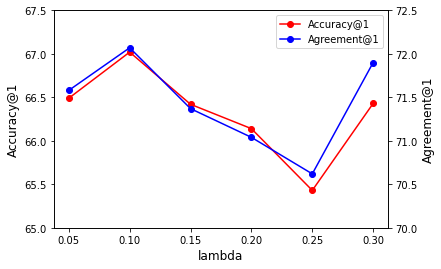

In [21]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
# width = 0.4
# x1_list = []
# x2_list = []
# for i in range(adv_acc.shape[0]):
#     x1_list.append(i)
#     x2_list.append(i + width)

# b1 = sns.lineplot(data=final_df, x="grad_of_adv", y="acc@1",color=sns.xkcd_rgb["pale red"] )  
b1, = plt.plot(l_dict["s_nce"], l_dict['Acc1'], '-ro', label='Accuracy@1')

# b1 = ax1.bar(x1_list, adv_acc, width=width, label='Acc@1', color=sns.xkcd_rgb["pale red"], tick_label=grad_range)
ax2 = ax1.twinx()
b2, = plt.plot(l_dict["s_nce"], l_dict['Agree1'], '-bo', label='Agreement@1')
# plt.grid('off')
# b2 = sns.lineplot(data=final_df, x="grad_of_adv", y="agree@1", color=sns.xkcd_rgb["denim blue"])
# b2 = ax2.bar(x2_list, adv_agg, width=width, label='Agree@1', color=sns.xkcd_rgb["denim blue"], tick_label=grad_range)
ax1.set_xlabel('lambda', fontsize=12)
ax1.set_ylabel('Accuracy@1', fontsize=12)
ax2.set_ylabel('Agreement@1', fontsize=12)
ax1.set_ylim(65, 67.5)
ax2.set_ylim(70, 72.5)
axs = [b1, b2]
lbs = [ax.get_label() for ax in axs]
ax1.legend(axs, lbs)
plt.savefig('lambda/acc_agg.pdf')

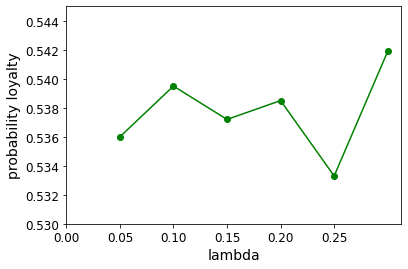

In [26]:
import numpy as np
plt.plot(l_dict["s_nce"], l_dict["Lp"], '-go', label="prob_loyalty")
plt.ylim(0.53, 0.545)
x_ticks = np.arange(0., 0.3, 0.05)
y_ticks = np.arange(0.53, 0.545, 0.002)
plt.xlabel('lambda', fontsize=14)
plt.ylabel('probability loyalty', fontsize=14)
plt.xticks(x_ticks, fontsize=12)
plt.yticks(y_ticks, fontsize=12)
plt.savefig('lambda/prob_loyalty.pdf')

In [38]:
k_dict_16384 = {
    'k': [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0],
    'accuracy@1': [93.06, 93.15,92.96,92.88, 93.06, 93.08, 93.04, 92.86, 92.87],
    'agreement@1': [95.11, 95.12, 95.11, 95.08, 95.31, 95.25, 95.00, 95.08, 95.11],
    'prob_loyalty': [0.8368, 0.8395, 0.8369, 0.8379, 0.8401, 0.8381, 0.8373, 0.8384, 0.8391]
    
}

k_dict_16384 = pd.DataFrame(data=k_dict_16384)
k_dict_16384

,k,accuracy@1,agreement@1,prob_loyalty
0,0.60,93.06,95.11,0.8368
1,0.65,93.15,95.12,0.8395
2,0.70,92.96,95.11,0.8369
3,0.75,92.88,95.08,0.8379
4,0.80,93.06,95.31,0.8401
5,0.85,93.08,95.25,0.8381
6,0.90,93.04,95.00,0.8373
7,0.95,92.86,95.08,0.8384
8,1.00,92.87,95.11,0.8391


In [40]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
# width = 0.4
# x1_list = []
# x2_list = []
# for i in range(adv_acc.shape[0]):
#     x1_list.append(i)
#     x2_list.append(i + width)

# b1 = sns.lineplot(data=final_df, x="grad_of_adv", y="acc@1",color=sns.xkcd_rgb["pale red"] )  
b1, = plt.plot(k_dict_16384["k"], k_dict_16384['accuracy@1'], '-ro', label='Accuracy@1')

# b1 = ax1.bar(x1_list, adv_acc, width=width, label='Acc@1', color=sns.xkcd_rgb["pale red"], tick_label=grad_range)
ax2 = ax1.twinx()
b2, = plt.plot(k_dict_16384["k"], k_dict_16384['agreement@1'], '-bo', label='Agreement@1')
# plt.grid('off')
# b2 = sns.lineplot(data=final_df, x="grad_of_adv", y="agree@1", color=sns.xkcd_rgb["denim blue"])
# b2 = ax2.bar(x2_list, adv_agg, width=width, label='Agree@1', color=sns.xkcd_rgb["denim blue"], tick_label=grad_range)
ax1.set_xlabel('k', fontsize=12)
ax1.set_ylabel('Accuracy@1', fontsize=12)
ax2.set_ylabel('Agreement@1', fontsize=12)
ax1.set_ylim(92.8, 93.2)
ax2.set_ylim(94.9, 95.4)
axs = [b1, b2]
lbs = [ax.get_label() for ax in axs]
ax1.legend(axs, lbs)
plt.savefig('k/acc_agg_16384.pdf')

<Figure size 432x288 with 2 Axes>

In [41]:
plt.plot(k_dict_16384["k"], k_dict_16384["prob_loyalty"], '-go', label="prob_loyalty")
plt.ylim(0.836, 0.841)
x_ticks = np.arange(0.6, 1.05, 0.05)
y_ticks = np.arange(0.836, 0.841, 0.001)
plt.xlabel('k', fontsize=14)
plt.ylabel('probability loyalty', fontsize=14)
plt.xticks(x_ticks, fontsize=12)
plt.yticks(y_ticks, fontsize=12)
plt.savefig('k/prob_loyalty_16384.pdf')

<Figure size 432x288 with 1 Axes>

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'pdf'
res_dict_below = {
    'method': ['teacher', 'teacher' ,'AdaDFKD(S)','AdaDFKD(S)','AdaDFKD(S)','AdaDFKD(S)','AdaDFKD(S)','AdaDFKD(S)','AdaDFKD(G)','AdaDFKD(G)','AdaDFKD(G)','AdaDFKD(G)','AdaDFKD(G)','AdaDFKD(G)','cudfkd', 'cudfkd', 'cmi', 'cmi', 'dafl', 'dafl', 'adi', 'adi', 'adi', 'adi', 'cudfkd', 'cudfkd', 'dafl', 'dafl', 'cmi', 'cmi', 'adi', 'adi', 'cmi', 'cmi', 'dafl', 'dafl', 'cudfkd', 'cudfkd'],
    'acc@1': [95.70, 94.07,94.67, 94.91, 94.92, 92.91,92.95,93.04,95.01,94.98,94.95, 93.10, 93.13, 93.18, 95.21, 92.90, 94.84, 91.97, 91.45 , 81.66, 93.26, 90.38, 90.36, 90.17, 95.24, 95.15, 82.89, 81.86, 91.95, 91.85,  93.18, 93.36,94.56, 94.63, 89.41, 89.04, 92.85, 93.02],
    'type': ['clean', 'noisy','clean', 'clean', 'clean', 'noisy', 'noisy','noisy','clean', 'clean', 'clean', 'noisy', 'noisy','noisy', 'clean', 'noisy','clean', 'noisy','clean', 'noisy','clean', 'noisy', 'noisy', 'noisy', 'clean', 'clean', 'noisy', 'noisy', 'noisy', 'noisy', 'clean', 'clean', 'clean', 'clean', 'clean', 'clean', 'noisy', 'noisy'],
    'agree@1':[100.00, 100.00, 97.48, 97.66, 97.65, 97.15,97.08,97.03, 97.88, 97.76,97.82, 96.94, 97.30, 97.35, 98.19, 93.86, 96.46, 94.99, 93.20, 83.85, 95.33, 92.88, 92.90, 92.92 , 98.20, 98.09, 85.03, 83.55, 94.98, 95.10,  95.23, 95.34, 96.96, 96.85,91.06, 90.69, 93.98, 93.94],
    'loyalty':[1.0000, 1.0000, 0.8790, 0.8843, 0.8829, 0.8911, 0.8908,0.8890,0.8841, 0.8833,0.8864, 0.8907, 0.8955, 0.8948, 0.8909, 0.8926, 0.8747, 0.8700, 0.7686, 0.6521, 0.8478, 0.8247, 0.8235, 0.8245, 0.8915, 0.8897, 0.6803, 0.6527, 0.8701, 0.8711,  0.8501,0.8499,0.8849, 0.8833, 0.7298, 0.7336, 0.8972, 0.8959],
}
for k, v in res_dict_below.items():
    print(len(v))
noisy_df = pd.DataFrame(data=res_dict_below)
noisy_df

38
38
38
38
38


,method,acc@1,type,agree@1,loyalty
0,teacher,95.70,clean,100.00,1.0000
1,teacher,94.07,noisy,100.00,1.0000
2,AdaDFKD(S),94.67,clean,97.48,0.8790
3,AdaDFKD(S),94.91,clean,97.66,0.8843
4,AdaDFKD(S),94.92,clean,97.65,0.8829
5,AdaDFKD(S),92.91,noisy,97.15,0.8911
6,AdaDFKD(S),92.95,noisy,97.08,0.8908
7,AdaDFKD(S),93.04,noisy,97.03,0.8890
8,AdaDFKD(G),95.01,clean,97.88,0.8841
9,AdaDFKD(G),94.98,clean,97.76,0.8833


In [26]:
# noisy_df.columns
import os
import numpy as np
if not os.path.exists('noisy/'):
    os.mkdir('noisy/')
plt.figure(figsize=(10, 5))
ax= sns.barplot(data=noisy_df, x='method', y='acc@1', hue='type', palette="plasma")
ax.set_ylim(80, 98)
ax.legend(loc='upper right', fontsize=15)
plt.xlabel('method', fontsize=18)
plt.ylabel('Acc@1', fontsize=18)
plt.xticks(range(7), labels=['teacher', 'AdaDFKD\n(S)','AdaDFKD\n(G)', 'CuDFKD', 'CMI', 'DAFL', 'ADI'], fontsize=15)
plt.yticks([80.0, 82.5, 85, 87.5, 90, 92.5, 95, 97.5], fontsize=15)
plt.savefig('noisy/acc.pdf')

<Figure size 720x360 with 1 Axes>

In [27]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=noisy_df, x='method', y='agree@1', hue='type',palette="Set2")
ax.set_ylim(80, 100)
ax.legend(loc='upper right')
plt.xlabel('method', fontsize=14)
plt.ylabel('Acc@1', fontsize=14)
plt.savefig('noisy/agg.pdf')

<Figure size 576x360 with 1 Axes>

In [28]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=noisy_df, x='method', y='loyalty', hue='type', palette="turbo")
ax.set_ylim(0.6, 1)
ax.legend(loc='upper right', fontsize=15)
plt.xlabel('method', fontsize=18)
plt.ylabel('Probability Loyalty', fontsize=18)
plt.xticks(range(7), labels=['teacher', 'AdaDFKD\n(S),Ours','AdaDFKD\n(G),Ours', 'CuDFKD', 'CMI', 'DAFL', 'ADI'], fontsize=15)
plt.yticks([0.6, 0.7, 0.8, 0.9, 1], fontsize=15)
plt.savefig('noisy/loyalty.pdf')

<Figure size 720x360 with 1 Axes>